# Random forest inference for data with non-normal distribution

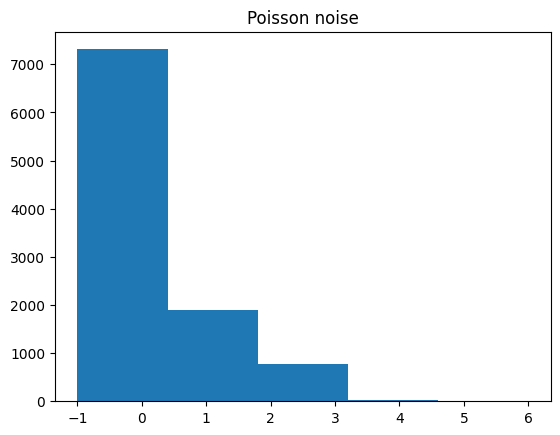

In [1]:
#%%
import numpy as np
from ml_uncertainty.model_inference import EnsembleModelInference
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

np.random.seed(1)

# Set up regression
# ====================
X = np.linspace(-10, 10, 10000).reshape((-1, 1))


def linear_model(X, coef_):
    return coef_[0] + np.dot(X, coef_[1:])


true_params = np.array([1.0, 1.0])
y_true = linear_model(X, true_params)

# Noise comes from a Poisson distribution.
noise = np.random.poisson(lam=1, size=X.shape[0]) - 1

y = y_true + noise

# Split into train and test.
train_idx = np.random.choice(
    np.arange(X.shape[0]), size=int(0.8 * X.shape[0]), replace=False
)

X_train = X[train_idx, :]
y_train = y[train_idx]
mask = np.ones(X.shape[0], dtype=bool)
mask[train_idx] = False
X_test = X[mask, :]
y_test = y[mask]

regr = RandomForestRegressor(
    max_depth=10, random_state=0, max_samples=0.7, n_estimators=500
)

regr.fit(X, y)

# Plot the noise
plt.figure()
plt.title("Poisson noise")
plt.hist(noise, bins=5)


def compute_coverage(df_int, y):
    """Gets coverage from the dataframe."""

    lower_bound = df_int["lower_bound"].values
    upper_bound = df_int["upper_bound"].values

    coverage = ((lower_bound < y) & (upper_bound > y)).sum() / y.shape[0]

    return coverage


In [2]:
#%%
# Model inference
# ====================

inf = EnsembleModelInference()


def poisson(scale=1, size=None):
    r"""Wrapper around numpy's Poisson function to specify scale.
    Note: For poisson, the mean, and variance are both=$\lambda$.
    So, we adjust for the mean, and "scale", i.e., standard deviation.
    """
    lam = scale ** 2
    return np.random.poisson(lam=lam, size=size) - lam


inf.set_up_model_inference(X_train, y_train, regr, distribution=poisson)

df_int_train = inf.get_intervals(X_train, is_train_data=True, confidence_level=90.0)[0]
coverage_train = compute_coverage(df_int_train, y_train)

df_int_test = inf.get_intervals(X_test, is_train_data=False, confidence_level=90.0)[0]
coverage_test = compute_coverage(df_int_test, y_test)

print(f"Coverage: Train set: {coverage_train}")
print(f"Coverage: Test set: {coverage_test}")


Coverage: Train set: 0.9
Coverage: Test set: 0.911


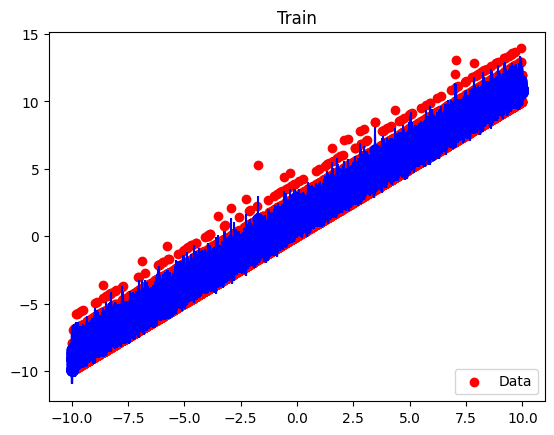

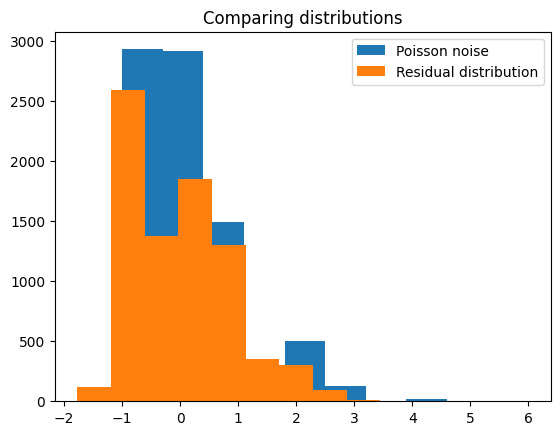

In [3]:
#%%
# Plot the prediction versus actual: Train data
plt.figure()
plt.title("Train")
plt.scatter(X_train[:, 0], y_train, marker="o", color="red", label="Data", zorder=0)
plt.scatter(X_train[:, 0], df_int_train["mean"].values, color="blue", zorder=0.9)
plt.errorbar(
    X_train[:, 0],
    df_int_train["mean"].values,
    yerr=(
        df_int_train["mean"] - df_int_train["lower_bound"],
        df_int_train["upper_bound"] - df_int_train["mean"],
    ),
    marker="o",
    markersize=8,
    ls="none",
    zorder=0.9,
    color="blue",
)
plt.legend(loc="lower right")

# Plot the distribution of residuals.
plt.figure()
plt.title("Comparing distributions")
plt.hist(noise[train_idx], bins=10, zorder=0.2, label="Poisson noise")
plt.hist(
    y_train - df_int_train["mean"], bins=10, zorder=0.2, label="Residual distribution"
)
plt.legend(loc="upper right")
